# Data Engineer Certification - Practical Exam - Supplement Experiments

1001-Experiments makes personalized supplements tailored to individual health needs.

1001-Experiments aims to enhance personal health by using data from wearable devices and health apps.

This data, combined with user feedback and habits, is used to analyze and refine the effectiveness of the supplements provided to the user through multiple small experiments.

The data engineering team at 1001-Experiments plays a crucial role in ensuring the collected health and activity data from thousands of users is accurately organized and integrated with the data from supplement usage. 

This integration helps 1001-Experiments provide more targeted health and wellness recommendations and improve supplement formulations.


## Task

1001-Experiments currently has the following four datasets with four months of data:
 - "user_health_data.csv" which logs daily health metrics, habits and data from wearable devices,
 - "supplement_usage.csv" which records details on supplement intake per user,
 - "experiments.csv" which contains metadata on experiments, and
 - "user_profiles.csv" which contains demographic and contact information of the users.

Each dataset contains unique identifiers for users and/or their supplement regimen.

The developers and data scientsits currently manage code that cross-references all of these data sources separately, which is cumbersome and error-prone.

Your manager has asked you to write a Python function that cleans and merges these datasets into a single dataset.

The final dataset should provide a comprehensive view of each user's health metrics, supplement usage, and demographic information.

- To test your code, your manager will run only the code `merge_all_data('user_health_data.csv', 'supplement_usage.csv', 'experiments.csv', 'user_profiles.csv')`
- Your `merge_all_data` function must return a DataFrame, with columns as described below.
- All columns must accurately match the descriptions provided below, including names.


## Data

The provided data is structured as follows:

![database schema](schema.png)

The function you write should return data as described below.

There should be a unique row for each daily entry combining health metrics and supplement usage.

Where missing values are permitted, they should be in the default Python format unless stated otherwise.

| Column Name        | Description |
|--------------------|-------------|
| user_id            | Unique identifier for each user. </br>There should not be any missing values. |
| date               | The date the health data was recorded or the supplement was taken, in date format. </br>There should not be any missing values. |
| email              | Contact email of the user. </br>There should not be any missing values. |
| user_age_group  | The age group of the user, one of: 'Under 18', '18-25', '26-35', '36-45', '46-55', '56-65', 'Over 65' or 'Unknown' where the age is missing.|
| experiment_name    | Name of the experiment associated with the supplement usage. </br>Missing values for users that have user health data only is permitted. |
| supplement_name    | The name of the supplement taken on that day. Multiple entries are permitted. </br>Days without supplement intake should be encoded as 'No intake'. |
| dosage_grams       | The dosage of the supplement taken in grams. Where the dosage is recorded in mg it should be converted by division by 1000.</br>Missing values for days without supplement intake are permitted. |
| is_placebo         | Indicator if the supplement was a placebo (true/false). </br>Missing values for days without supplement intake are permitted. |
| average_heart_rate | Average heart rate as recorded by the wearable device. </br>Missing values are permitted. |
| average_glucose    | Average glucose levels as recorded on the wearable device. </br>Missing values are permitted. |
| sleep_hours        | Total sleep in hours for the night preceding the current day’s log. </br>Missing values are permitted. |
| activity_level     | Activity level score between 0-100. </br>Missing values are permitted. |

# Imports

In [1086]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Loading files from csv

In [1087]:
# loading files 
experiments = pd.read_csv('experiments.csv')
supplement_usage = pd.read_csv('supplement_usage.csv')
user_profiles = pd.read_csv('user_profiles.csv')
user_health_data = pd.read_csv('user_health_data.csv')

# Datasets overview

## experiments table 

In [1088]:
experiments

,experiment_id,name,description
0,d655666f-725d-4312-96b4-df25045dd08e,Endurance,Improve how long aerobic physical activities c...
1,33c1bd33-b41a-4773-a001-873307be57e9,Strength,Improve the maximum strength in different ranges.
2,85d2741f-7964-49d4-bc1d-62f0a50d8a59,Sleep Quality,Examine the impact of different conditions on ...
3,14fb6430-c228-407c-ba66-a35588b98276,Focus,Affect the ability to concentrate and maintain...
4,2a8e0839-ed8f-4409-8aab-c4abf7cb1185,Memory,Evaluate techniques to improve short-term and ...
5,ce7f2178-4f42-4511-ab41-06b8cf717f7c,Recovery,"Investigate recovery speeds after exertion, fo..."


In [1089]:
experiments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   experiment_id  6 non-null      object
 1   name           6 non-null      object
 2   description    6 non-null      object
dtypes: object(3)
memory usage: 272.0+ bytes


## supplement_usage table

In [1090]:
supplement_usage.head()

,user_id,date,supplement_name,dosage,dosage_unit,is_placebo,experiment_id
0,38bbb850-2b41-47a2-b287-833317055c1a,2018-04-30,Vitamin C,380.742204,mg,False,14fb6430-c228-407c-ba66-a35588b98276
1,73420928-0991-41c2-9e31-930b18b61f95,2018-03-31,Magnesium,115.521810,mg,True,d655666f-725d-4312-96b4-df25045dd08e
2,1e9c58f2-86da-4025-88cb-b4d8dc8c889d,2018-01-31,Vitamin C,482.849678,mg,True,d655666f-725d-4312-96b4-df25045dd08e
3,59d3b4eb-5ad8-4d95-a4b2-9c4dfb9d3e9c,2018-01-31,Vitamin C,118.511952,mg,False,85d2741f-7964-49d4-bc1d-62f0a50d8a59
4,a89c9636-6e24-40f1-a2eb-c9bcec783f0f,2018-03-31,Vitamin C,452.501273,mg,False,ce7f2178-4f42-4511-ab41-06b8cf717f7c


In [1091]:
supplement_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          2000 non-null   object 
 1   date             2000 non-null   object 
 2   supplement_name  2000 non-null   object 
 3   dosage           2000 non-null   float64
 4   dosage_unit      2000 non-null   object 
 5   is_placebo       2000 non-null   bool   
 6   experiment_id    2000 non-null   object 
dtypes: bool(1), float64(1), object(5)
memory usage: 95.8+ KB


In [1092]:
supplement_usage.describe()

,dosage
count,2000.000000
mean,300.783660
std,114.325805
min,101.349177
25%,202.685907
50%,299.153171
75%,395.381184
max,499.957067


In [1093]:
supplement_usage.duplicated().sum()

0

## user_profiles table 

In [1094]:
user_profiles.head()

,user_id,email,age
0,c6ae338a-9f95-481c-a88d-24a58bc8fc71,hi_1@example.com,68.0
1,5346f1dc-30f7-4e3a-9d35-eec6cb8835fa,hi_2@myemail.com,64.0
2,5541289d-fa9f-4aef-9504-1e11d940efc5,hello_3@example.com,40.0
3,f8461502-54b8-4388-ae0d-9095cfc0426f,hi4@myemail.com,33.0
4,9e4781d1-111b-4318-907f-63c58da6cd89,user_5@myemail.com,48.0


In [1095]:
user_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  500 non-null    object 
 1   email    500 non-null    object 
 2   age      450 non-null    float64
dtypes: float64(1), object(2)
memory usage: 11.8+ KB


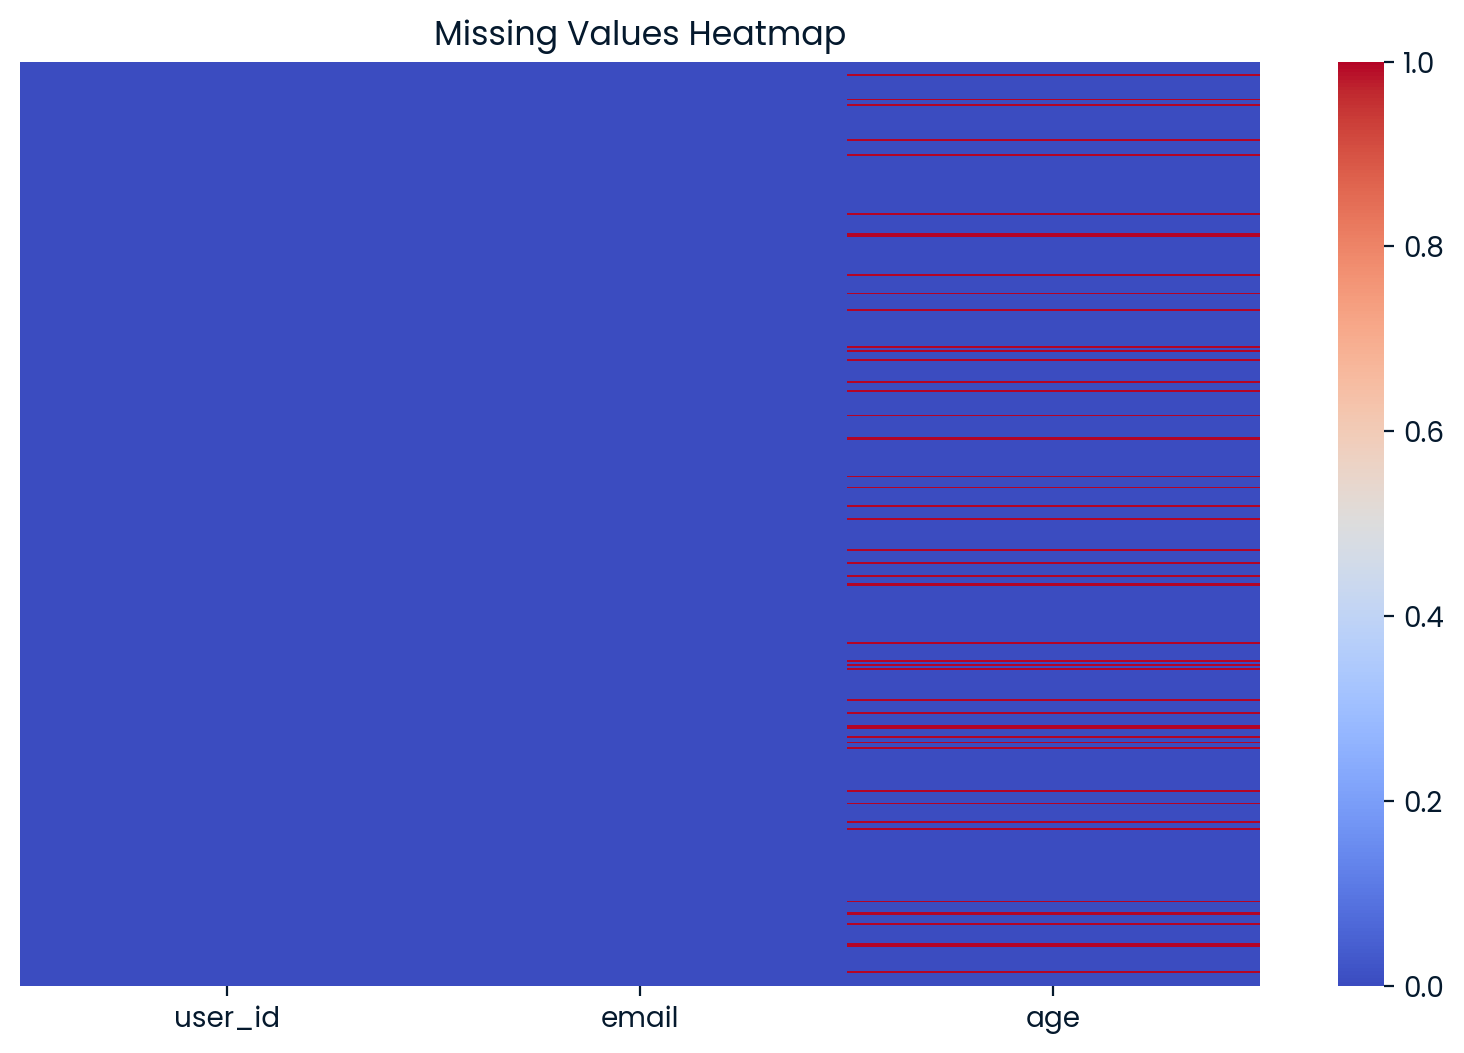

In [1096]:
plt.figure(figsize=(10, 6))
sns.heatmap(user_profiles.isnull(), yticklabels=False, cmap='coolwarm')
plt.title('Missing Values Heatmap')
plt.show()

In [1097]:
user_profiles.describe()

,age
count,450.000000
mean,44.084444
std,15.411562
min,18.000000
25%,30.000000
50%,45.000000
75%,57.000000
max,69.000000


In [1098]:
user_profiles.duplicated().sum()

0

In [1099]:
email_pattern = r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'

# placeholder for incorrect emails
faulty_emails = [email for email in user_profiles['email'] if not re.match(email_pattern, str(email))]

# print result
print(f"Found {len(faulty_emails)} faulty email addresses:")
for email in faulty_emails:
    print(email)

Found 0 faulty email addresses:


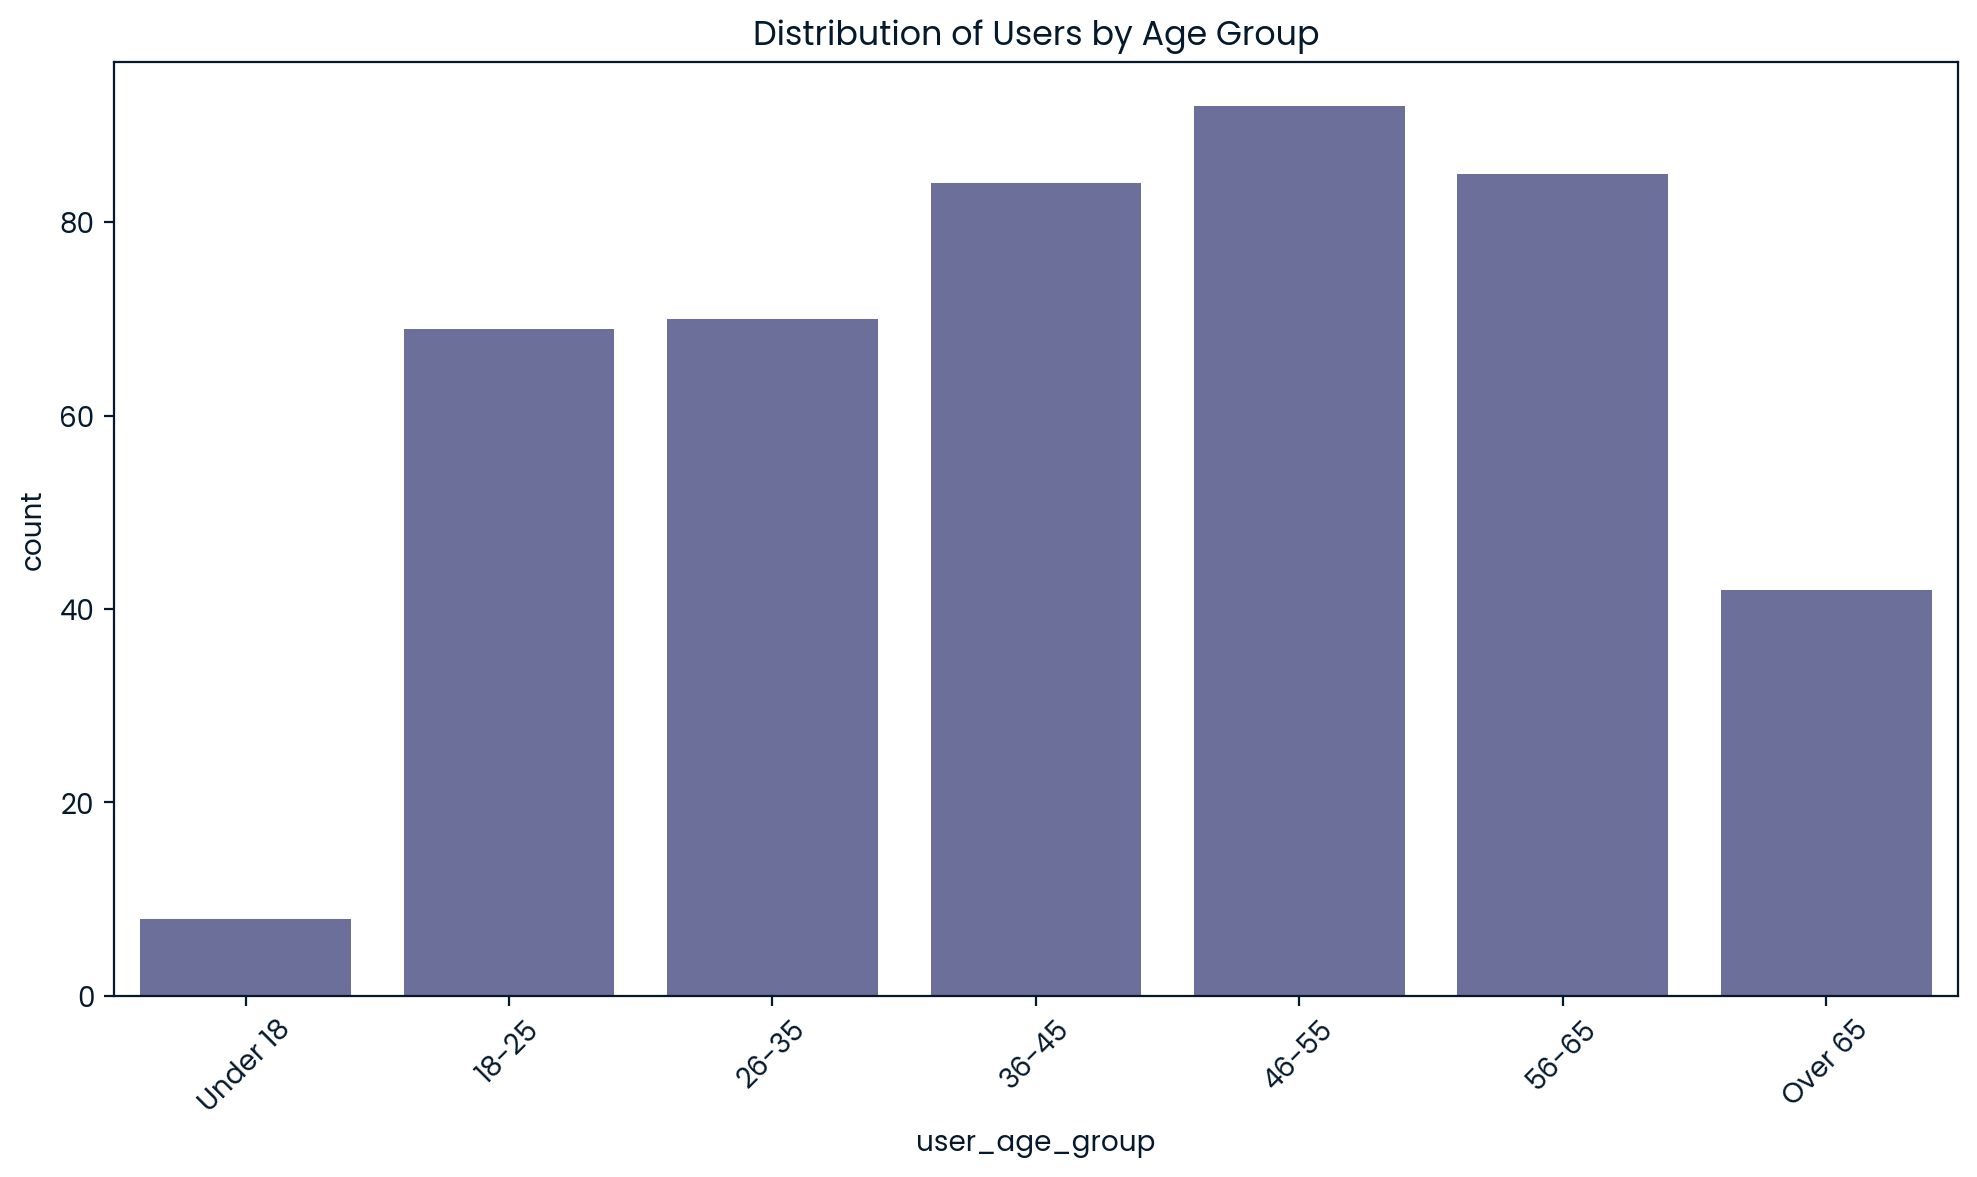

In [1100]:
user_profiles['user_age_group'] = pd.cut(user_profiles['age'], 
                             bins=[0, 18, 25, 35, 45, 55, 65, float('inf')],
                             labels=['Under 18', '18-25', '26-35', '36-45', '46-55', '56-65', 'Over 65'],
                             include_lowest=True)

# Age Group Analysis
plt.figure(figsize=(10, 6))
sns.countplot(data=user_profiles, x='user_age_group')
plt.title('Distribution of Users by Age Group')
plt.xticks(rotation=45)
plt.tight_layout()

## user_health_data table

In [1101]:
user_health_data.head()

,user_id,date,average_heart_rate,average_glucose,sleep_hours,activity_level
0,c6ae338a-9f95-481c-a88d-24a58bc8fc71,2018-01-31,93.055612,70.089910,8.8h,1
1,c6ae338a-9f95-481c-a88d-24a58bc8fc71,2018-02-28,88.059964,78.411148,8.0H,3
2,c6ae338a-9f95-481c-a88d-24a58bc8fc71,2018-03-31,78.373746,107.418818,11.9h,1
3,c6ae338a-9f95-481c-a88d-24a58bc8fc71,2018-04-30,62.204061,117.259092,5.1h,1
4,5346f1dc-30f7-4e3a-9d35-eec6cb8835fa,2018-01-31,77.075789,99.221380,9.6h,2


In [1102]:
user_health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             2000 non-null   object 
 1   date                2000 non-null   object 
 2   average_heart_rate  2000 non-null   float64
 3   average_glucose     2000 non-null   float64
 4   sleep_hours         2000 non-null   object 
 5   activity_level      2000 non-null   int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 93.9+ KB


In [1103]:
user_health_data.describe()

,average_heart_rate,average_glucose,activity_level
count,2000.000000,2000.000000,2000.000000
mean,79.742453,104.219847,2.521500
std,11.514368,19.810373,1.123018
min,60.009640,70.003698,1.000000
25%,69.711381,87.653811,2.000000
50%,79.537022,103.876035,3.000000
75%,89.745009,120.741650,4.000000
max,99.978427,139.903212,4.000000


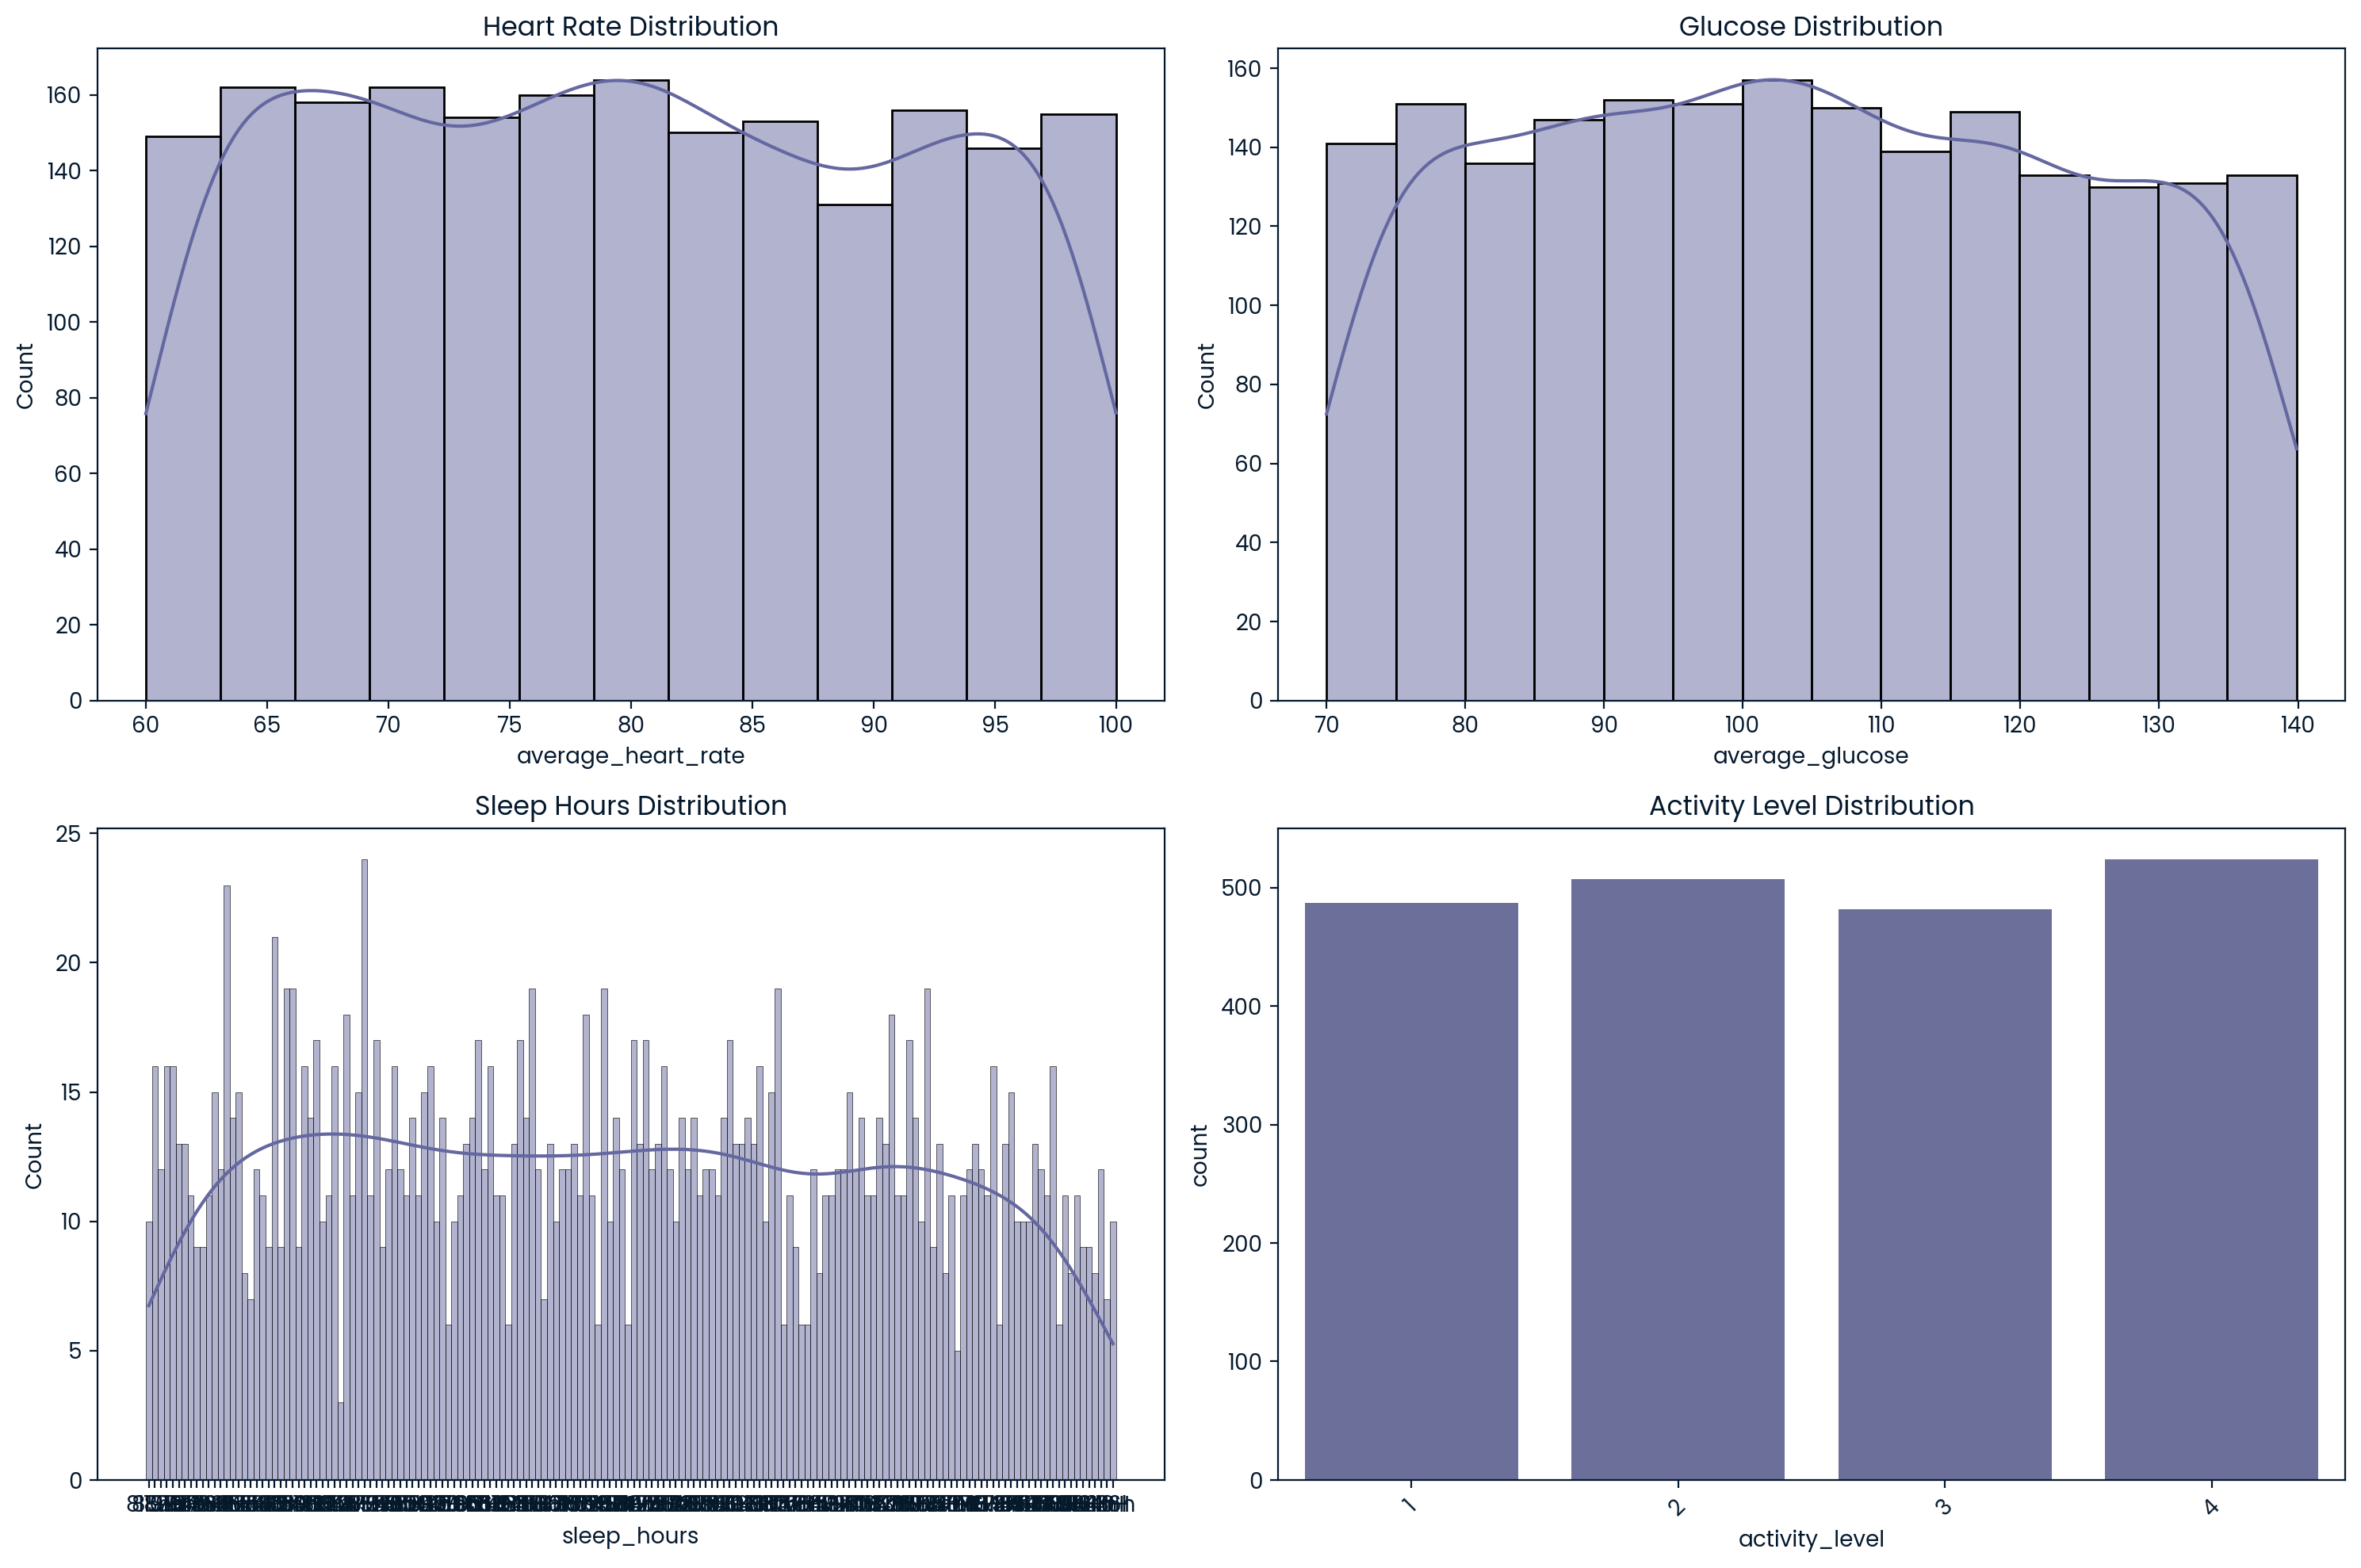

In [1104]:
# Distribution Plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Heart Rate Distribution
sns.histplot(data=user_health_data, x='average_heart_rate', kde=True, ax=axes[0,0])
axes[0,0].set_title('Heart Rate Distribution')

# Glucose Distribution
sns.histplot(data=user_health_data, x='average_glucose', kde=True, ax=axes[0,1])
axes[0,1].set_title('Glucose Distribution')

# Sleep Hours Distribution
sns.histplot(data=user_health_data, x='sleep_hours', kde=True, ax=axes[1,0])
axes[1,0].set_title('Sleep Hours Distribution')

# Activity Level Distribution
sns.countplot(data=user_health_data, x='activity_level', ax=axes[1,1])
axes[1,1].set_title('Activity Level Distribution')
plt.xticks(rotation=45)

plt.tight_layout()

In [1105]:
user_health_data.duplicated().sum()

0

## Writing the function 

In [1106]:
def merge_all_data(health_data_path, supplement_path, experiments_path, profiles_path):

    # importing pandas
    import pandas as pd
    from datetime import datetime

    # loading csv files
    user_health_data = pd.read_csv(health_data_path)
    supplement_usage = pd.read_csv(supplement_path)
    experiments = pd.read_csv(experiments_path)
    user_profiles = pd.read_csv(profiles_path)
    
    # cleaning user profile
    valid_age_groups = ['Under 18', '18-25', '26-35', '36-45', '46-55', '56-65', 'Over 65']
    user_profiles['user_age_group'] = pd.cut(user_profiles['age'], 
                                bins=[0, 18, 25, 35, 45, 55, 65, float('inf')],
                                labels=valid_age_groups,
                                include_lowest=True)
    user_profiles.drop('age', axis=1, inplace=True)
    user_profiles['user_age_group'] = user_profiles['user_age_group'].astype(str)
    user_profiles['user_age_group'] = user_profiles['user_age_group'].apply(lambda x: x if x in valid_age_groups else 'Unknown')
    
    # cleaning user health data 
    user_health_data['date'] = pd.to_datetime(user_health_data['date'])  # Removed strftime
    user_health_data['sleep_hours'] = user_health_data['sleep_hours'].str.replace('h|H', '', regex=True).astype(float)
    
    # clearning supplement_usage
    supplement_usage['date'] = pd.to_datetime(supplement_usage['date'])  # Removed strftime
    supplement_usage['dosage_grams'] = supplement_usage['dosage'] / 1000
    supplement_usage.drop('dosage', axis=1, inplace=True)
    supplement_usage.drop('dosage_unit', axis=1, inplace=True)
    
    # cleaning experiments
    experiments.rename(columns={'name': 'experiment_name'}, inplace=True)
    experiments.drop('description', axis=1, inplace=True)
    
    # merging all tables into one
    merged_one = pd.merge(user_profiles, user_health_data, on='user_id', how='left')
    merged_two = pd.merge(left=merged_one, right=supplement_usage, on=['user_id', 'date'], how='left')
    final_merge = pd.merge(left=merged_two, right=experiments, on='experiment_id', how='left')
    
    # cleaning merged tables
    final_merge['supplement_name'] = final_merge['supplement_name'].fillna('No intake')
    final_merge.drop('experiment_id', axis=1, inplace=True)
    final_merge['date'] = pd.to_datetime(final_merge['date'])  # Removed strftime
    
    # rearrange columns 
    correct_order = ['user_id', 'date', 'email', 'user_age_group', 'experiment_name', 'supplement_name', 'dosage_grams', 'is_placebo', 'average_heart_rate', 'average_glucose', 'sleep_hours', 'activity_level']
    final_table = final_merge[correct_order]
    
    # returning final table 
    return final_table

## Testing the function

In [1107]:
merge_all_data('user_health_data.csv', 'supplement_usage.csv', 'experiments.csv', 'user_profiles.csv')

,user_id,date,email,user_age_group,experiment_name,supplement_name,dosage_grams,is_placebo,average_heart_rate,average_glucose,sleep_hours,activity_level
0,c6ae338a-9f95-481c-a88d-24a58bc8fc71,2018-01-31,hi_1@example.com,Over 65,Sleep Quality,Zinc,0.149315,False,93.055612,70.089910,8.8,1
1,c6ae338a-9f95-481c-a88d-24a58bc8fc71,2018-02-28,hi_1@example.com,Over 65,NaN,No intake,NaN,NaN,88.059964,78.411148,8.0,3
2,c6ae338a-9f95-481c-a88d-24a58bc8fc71,2018-03-31,hi_1@example.com,Over 65,Endurance,Magnesium,0.239949,True,78.373746,107.418818,11.9,1
3,c6ae338a-9f95-481c-a88d-24a58bc8fc71,2018-03-31,hi_1@example.com,Over 65,Focus,Placebo,0.416022,False,78.373746,107.418818,11.9,1
4,c6ae338a-9f95-481c-a88d-24a58bc8fc71,2018-04-30,hi_1@example.com,Over 65,Recovery,Placebo,0.324913,False,62.204061,117.259092,5.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2716,9c083dc3-b789-4cee-87fb-9887ff4b4e29,2018-04-30,contact499@myemail.com,46-55,NaN,No intake,NaN,NaN,88.575502,121.997505,7.9,3
2717,2f2aa322-d2b2-4c88-aeb6-e49e768521f3,2018-01-31,hello_500@myemail.com,46-55,NaN,No intake,NaN,NaN,96.665724,73.559778,9.9,1
2718,2f2aa322-d2b2-4c88-aeb6-e49e768521f3,2018-02-28,hello_500@myemail.com,46-55,Strength,Vitamin C,0.280467,False,88.219866,85.478628,7.9,4
2719,2f2aa322-d2b2-4c88-aeb6-e49e768521f3,2018-03-31,hello_500@myemail.com,46-55,NaN,No intake,NaN,NaN,86.871171,89.198330,7.9,3


In [1108]:
final_table = merge_all_data('user_health_data.csv', 'supplement_usage.csv', 'experiments.csv', 'user_profiles.csv')

In [1109]:
final_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2721 entries, 0 to 2720
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             2721 non-null   object        
 1   date                2721 non-null   datetime64[ns]
 2   email               2721 non-null   object        
 3   user_age_group      2721 non-null   object        
 4   experiment_name     2000 non-null   object        
 5   supplement_name     2721 non-null   object        
 6   dosage_grams        2000 non-null   float64       
 7   is_placebo          2000 non-null   object        
 8   average_heart_rate  2721 non-null   float64       
 9   average_glucose     2721 non-null   float64       
 10  sleep_hours         2721 non-null   float64       
 11  activity_level      2721 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(6)
memory usage: 276.4+ KB


In [1110]:
final_table.sample(10)

,user_id,date,email,user_age_group,experiment_name,supplement_name,dosage_grams,is_placebo,average_heart_rate,average_glucose,sleep_hours,activity_level
2397,1a46798a-036d-43ab-a1b7-41b139fa8436,2018-02-28,hi439@email.com,36-45,Memory,Placebo,0.181048,False,69.362311,84.788404,10.0,1
383,c6dabe5d-c8f9-428c-88f5-069037fe6600,2018-03-31,hello_71@example.com,Over 65,Memory,Placebo,0.488917,False,88.722726,92.146279,11.9,1
236,26b710d2-7682-4baa-a935-803dd7857f65,2018-01-31,user_43@email.com,Unknown,Memory,Placebo,0.245896,False,69.744592,81.079814,8.3,1
474,c7aba1fb-1abd-4744-a3bb-f5f4393deb6d,2018-02-28,hi_89@example.com,56-65,Strength,Magnesium,0.215337,False,89.304508,78.532245,10.4,1
2045,e05e4447-63fb-459c-927e-a09b19a8f6e8,2018-04-30,contact_373@example.com,56-65,Strength,Placebo,0.241007,True,62.977137,106.200525,6.2,1
95,9a7cb47b-3798-4ed4-8953-9f8c638c22a7,2018-02-28,contact17@myemail.com,46-55,Recovery,Zinc,0.169246,False,89.409141,84.010795,10.6,2
2713,9c083dc3-b789-4cee-87fb-9887ff4b4e29,2018-03-31,contact499@myemail.com,46-55,Strength,Zinc,0.384945,False,83.231873,120.255592,5.6,4
235,26b710d2-7682-4baa-a935-803dd7857f65,2018-01-31,user_43@email.com,Unknown,Strength,Omega-3,0.483443,False,69.744592,81.079814,8.3,1
1348,7f8512e8-2647-49e3-8cf4-fa53b3f191bc,2018-03-31,hello248@myemail.com,Unknown,Endurance,Zinc,0.247902,False,63.140395,90.080681,6.6,3
1050,fea88af8-f0e5-4775-bf85-ee4863adc06d,2018-02-28,hello_194@example.com,36-45,Focus,Vitamin C,0.109240,False,98.736765,92.207865,5.0,2
